In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys
from torch.autograd import Variable
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import multiprocess as mp
import torchvision
import piq

ref_image = np.load('Reference_fan_in.npz')['data']
training_data_images = np.load('Training_data_on_LCD_fanned_in.npz')['train']
training_data_labels = np.load('Binary_Pixel_MNIST_Data_for_LCD_Microlens_120_120.npz')['labels']
orig_training_images = np.load('Binary_Pixel_MNIST_Data_for_LCD_Microlens_120_120.npz')['digits']
testing_data_images = np.load('Testing_data_on_LCD_fanned_in.npz')['test']
testing_data_labels = np.load('Binary_Pixel_MNIST_Data_for_LCD_Microlens_120_120_test.npz')['labels']
orig_testing_images = np.load('Binary_Pixel_MNIST_Data_for_LCD_Microlens_120_120_test.npz')['digits']
data_images = np.concatenate((training_data_images, testing_data_images))
data_labels = np.concatenate((training_data_labels, testing_data_labels))

print(training_data_images.shape[0])
print(testing_data_images.shape[0])

2000
300


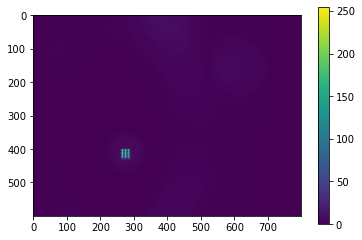

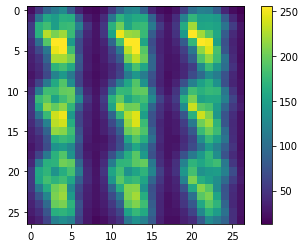

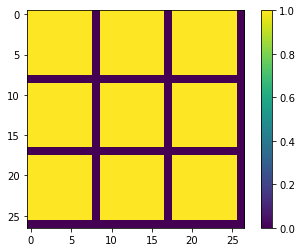

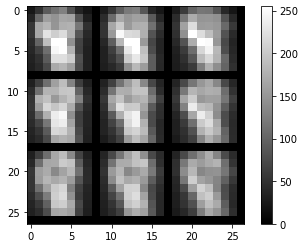

In [83]:
#Reference Image for bounding boxes
plt.figure()
plt.imshow(ref_image)
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(ref_image[400:427, 263:290])
plt.colorbar()
plt.show()

window_mat = np.zeros((9, 9))
window_mat[0:8, 0:8] = 1
window_mat = np.tile(window_mat, (3,3))
plt.figure()
plt.imshow(window_mat)
plt.colorbar()
plt.show()

Fanned_in_image = np.copy(ref_image[400:427, 263:290])*window_mat
plt.figure()
plt.imshow(Fanned_in_image, cmap = 'gray')
plt.colorbar()
plt.show()

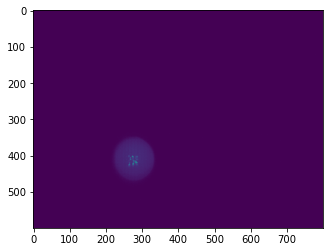

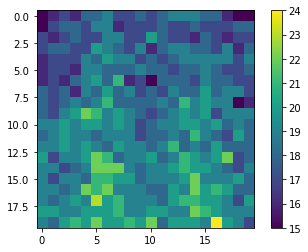

In [39]:
#Noise Subtraction
ind = 0
plt.figure()
plt.imshow(training_data_images[ind])
plt.show()

plt.figure()
plt.imshow(training_data_images[ind][370:390, 270:290])
plt.colorbar()
plt.show()

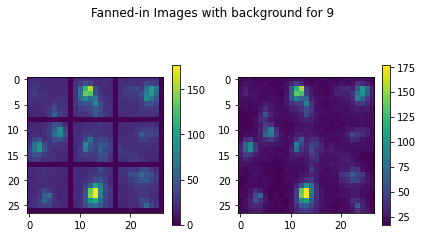

Noise = 18.715


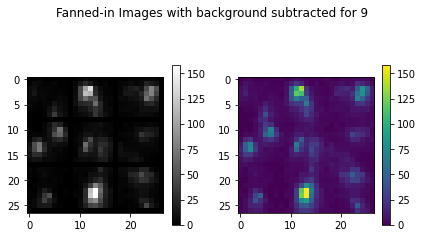

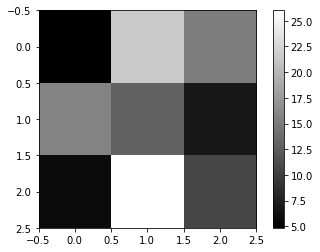

[[ 4.85867187 21.50375    15.2225    ]
 [15.76046875 12.91        6.81625   ]
 [ 5.82523438 26.01492187 10.66      ]]
[ 4.85867187 21.50375    15.2225     15.76046875 12.91        6.81625
  5.82523438 26.01492187 10.66      ]


In [90]:
ind = 4
lab = training_data_labels[ind]
window_mat = np.zeros((9, 9))
window_mat[0:8, 0:8] = 1
window_mat = np.tile(window_mat, (3,3))

Fanned_in_image = training_data_images[ind][400:427, 263:290]*window_mat

fig, axes = plt.subplots(1, 2)
im = axes[0].imshow(Fanned_in_image)
plt.colorbar(im, ax = axes[0], shrink = 0.6)
im = axes[1].imshow(training_data_images[ind][400:427, 263:290])
plt.colorbar(im, ax = axes[1], shrink = 0.6)
plt.tight_layout()
plt.suptitle(f'Fanned-in Images with background for {lab}')
plt.show()

noise = np.mean(training_data_images[ind][370:390, 270:290])
print(f'Noise = {noise}')

fig, axes = plt.subplots(1, 2)
im = axes[0].imshow(np.maximum(Fanned_in_image - noise, 0), cmap = 'gray')
plt.colorbar(im, ax = axes[0], shrink = 0.6)
im = axes[1].imshow(np.maximum(training_data_images[ind][400:427, 263:290] - noise, 0))
plt.colorbar(im, ax = axes[1], shrink = 0.6)
plt.tight_layout()
plt.suptitle(f'Fanned-in Images with background subtracted for {lab}')
plt.show()

compressed_vec_image = np.copy(np.maximum(Fanned_in_image - noise, 0))

n1 = 9
n2 = 9
b = compressed_vec_image.shape[0]//n1
compressed_vec = compressed_vec_image.reshape(-1, n1, b, n2).sum((-1, -3))/(8*8)

plt.figure()
plt.imshow(compressed_vec, cmap = 'gray')
plt.colorbar()
plt.show()

print(compressed_vec)
print(compressed_vec.reshape(9))

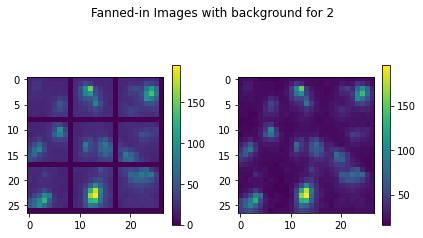

Noise = 18.6275


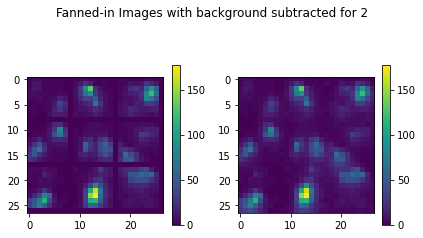

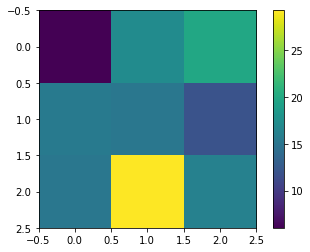

[[ 6.03671875 17.200625   19.96625   ]
 [15.54835938 15.231875   11.919375  ]
 [15.21042969 29.20460938 16.2475    ]]
[ 6.03671875 17.200625   19.96625    15.54835938 15.231875   11.919375
 15.21042969 29.20460938 16.2475    ]


In [51]:
ind = 5
lab = training_data_labels[ind]
window_mat = np.zeros((9, 9))
window_mat[0:8, 0:8] = 1
window_mat = np.tile(window_mat, (3,3))

Fanned_in_image = training_data_images[ind][400:427, 263:290]*window_mat

fig, axes = plt.subplots(1, 2)
im = axes[0].imshow(Fanned_in_image)
plt.colorbar(im, ax = axes[0], shrink = 0.6)
im = axes[1].imshow(training_data_images[ind][400:427, 263:290])
plt.colorbar(im, ax = axes[1], shrink = 0.6)
plt.tight_layout()
plt.suptitle(f'Fanned-in Images with background for {lab}')
plt.show()

noise = np.mean(training_data_images[ind][370:390, 270:290])
print(f'Noise = {noise}')

fig, axes = plt.subplots(1, 2)
im = axes[0].imshow(np.maximum(Fanned_in_image - noise, 0))
plt.colorbar(im, ax = axes[0], shrink = 0.6)
im = axes[1].imshow(np.maximum(training_data_images[ind][400:427, 263:290] - noise, 0))
plt.colorbar(im, ax = axes[1], shrink = 0.6)
plt.tight_layout()
plt.suptitle(f'Fanned-in Images with background subtracted for {lab}')
plt.show()

compressed_vec_image = np.copy(np.maximum(Fanned_in_image - noise, 0))

n1 = 9
n2 = 9
b = compressed_vec_image.shape[0]//n1
compressed_vec = compressed_vec_image.reshape(-1, n1, b, n2).sum((-1, -3))/(8*8)

plt.figure()
plt.imshow(compressed_vec)
plt.colorbar()
plt.show()

print(compressed_vec)
print(compressed_vec.reshape(9))

In [63]:
class Opticallly_compressed_MNIST_Dataset(Dataset):
    def __init__(self, mode) :
        self.mode = mode
        self.data = []
        self.labels = []
        self.window_mat = np.zeros((9, 9))
        self.window_mat[0:8, 0:8] = 1
        self.window_mat = np.tile(self.window_mat, (3,3))
        if (mode == 'train'):
            for p in range (training_data_images.shape[0]):
                noise = np.mean(training_data_images[p][370:390, 270:290])
                Fanned_in_image = np.maximum(training_data_images[p][400:427, 263:290]*self.window_mat - noise, 0)
                n1 = 9
                n2 = 9
                b = compressed_vec_image.shape[0]//n1
                compressed_vec = Fanned_in_image.reshape(-1, n1, b, n2).sum((-1, -3))/(8*8)
                compressed_vec = compressed_vec.reshape(9)
                compressed_vec = compressed_vec/compressed_vec.max()
                self.data.append(torch.tensor(compressed_vec, dtype = torch.float32))
                orig_image = torchvision.transforms.Resize((14, 14))(torch.tensor(orig_training_images[p], \
                                                                     dtype = torch.float32).view(1, 120, 120))
                self.labels.append(orig_image.reshape(14*14))
        if (mode == 'test'):
            for p in range (testing_data_images.shape[0]):
                noise = np.mean(testing_data_images[p][370:390, 270:290])
                Fanned_in_image = np.maximum(testing_data_images[p][400:427, 263:290]*self.window_mat - noise, 0)
                n1 = 9
                n2 = 9
                b = compressed_vec_image.shape[0]//n1
                compressed_vec = Fanned_in_image.reshape(-1, n1, b, n2).sum((-1, -3))/(8*8)
                compressed_vec = compressed_vec.reshape(9)
                compressed_vec = compressed_vec/compressed_vec.max()
                self.data.append(torch.tensor(compressed_vec, dtype = torch.float32))
                orig_image = torchvision.transforms.Resize((14, 14))(torch.tensor(orig_testing_images[p], \
                                                                     dtype = torch.float32).view(1, 120, 120))
                self.labels.append(orig_image.reshape(14*14))
                
    def __len__(self) :
        return len(self.labels)
        
    def __getitem__(self, idx) :
        return self.data[idx], self.labels[idx]

train_data = Opticallly_compressed_MNIST_Dataset('train')
test_data = Opticallly_compressed_MNIST_Dataset('test')

torch.Size([9])


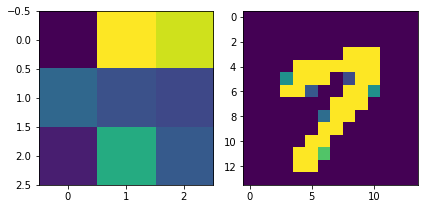

7
torch.Size([9])


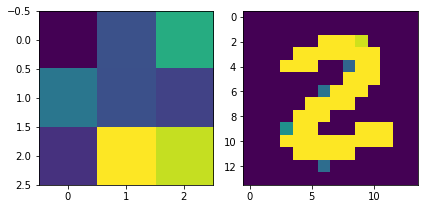

2
torch.Size([9])


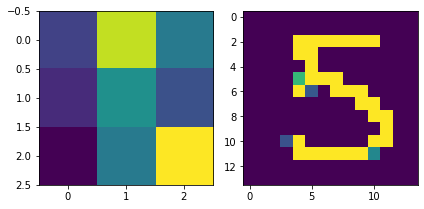

5
torch.Size([9])


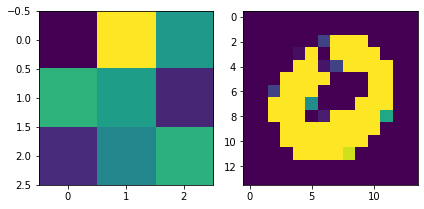

0
2000
300


In [96]:
for i,data in enumerate(train_data):
    if(i==15):
        print(data[0].shape)
        fig, axes = plt.subplots(1, 2)
        im = axes[0].imshow(data[0].reshape(3, 3))
        im = axes[1].imshow(data[1].reshape(14, 14))
        plt.tight_layout()
        plt.show()
        print(training_data_labels[i])
    if(i==25):
        print(data[0].shape)
        fig, axes = plt.subplots(1, 2)
        im = axes[0].imshow(data[0].reshape(3, 3))
        im = axes[1].imshow(data[1].reshape(14, 14))
        plt.tight_layout()
        plt.show()
        print(training_data_labels[i])
N_train_samp = i + 1
for i,data in enumerate(test_data):
    if(i==15):
        print(data[0].shape)
        fig, axes = plt.subplots(1, 2)
        im = axes[0].imshow(data[0].reshape(3, 3))
        im = axes[1].imshow(data[1].reshape(14, 14))
        plt.tight_layout()
        plt.show()
        print(testing_data_labels[i])
    if(i==25):
        print(data[0].shape)
        fig, axes = plt.subplots(1, 2)
        im = axes[0].imshow(data[0].reshape(3, 3))
        im = axes[1].imshow(data[1].reshape(14, 14))
        plt.tight_layout()
        plt.show()
        print(testing_data_labels[i])
N_test_samp = i + 1

print(N_train_samp)
print(N_test_samp)

In [67]:
batch_size = 50
train_dataset = DataLoader(train_data, batch_size = batch_size, shuffle = False)
test_dataset = DataLoader(test_data, batch_size = batch_size, shuffle = False)
N_train_batch = int(N_train_samp/batch_size)
N_test_batch = int(N_test_samp/batch_size)
print(N_train_batch)
print(N_test_batch)

40
6


In [68]:
#Device
dev = 'cuda:3'
device = torch.device(dev if torch.cuda.is_available() else "cpu")
if (device != "cpu") :
    with torch.cuda.device(dev):
        torch.cuda.empty_cache()
        
class Decoder(nn.Module):
    def __init__(self, n_inps, batch):
        super(Decoder, self).__init__()
        self.n_inputs = n_inps
        self.FCmu = nn.Linear(self.n_inputs, self.n_inputs, bias = True)
        self.FCvar = nn.Linear(self.n_inputs, self.n_inputs, bias = True)
        self.FC2 = nn.Linear(self.n_inputs, 100, bias = True)
        self.FC3 = nn.Linear(100, 196, bias = True)
        
    def reparametrize(self,mu,log_var):
        #Reparametrization Trick to allow gradients to backpropagate from the 
        #stochastic part of the model
        sigma = torch.exp(0.5*log_var)
        z = torch.randn(size = (mu.size(0),mu.size(1)))
        z = z.type_as(mu) # Setting z to be .cuda when using GPU training 
        return mu + sigma*z
        
    def forward(self, X):
        mu = self.FCmu(X)
        var = self.FCvar(X)
        Y = self.reparametrize(mu, var)
        Y = F.relu(Y)
        Y = self.FC2(Y)
        Y = F.relu(Y)
        Y = self.FC3(Y)
        return torch.sigmoid(Y), mu, var

In [69]:
def kl_loss(mu, log_var):
    return (-0.5*(1+log_var - mu**2- torch.exp(log_var)).sum(dim = 1)).mean(dim =0) 

In [72]:
dataiter = iter(train_dataset)
if (device != "cpu") :
    with torch.cuda.device(dev):
        torch.cuda.empty_cache()
        
pixels = 14
with torch.no_grad():
    digits, labels = dataiter.next()
    digits = digits.to(device)
    labels = labels.to(device)
    print(digits.shape)
    model = Decoder(9, batch_size).to(device)
    output, mean, std = model(digits)
    print(output.shape)
    
criterion = nn.MSELoss(reduction = 'sum')
#criterion = piq.SSIMLoss(data_range = 1.)
print(criterion(output, labels) + kl_loss(mean, std))

torch.Size([50, 9])
torch.Size([50, 196])
tensor(2364.8521, device='cuda:3')


In [76]:
learn_rate = 1e-3
criterion = nn.MSELoss(reduction = 'sum')
#criterion = piq.SSIMLoss(data_range = 1.)
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
Epochs = 100
if (device != "cpu") :
    with torch.cuda.device(dev):
        torch.cuda.empty_cache()
        
loss_train = []
loss_test = []
for epoch in range(Epochs):# loop over the dataset multiple times
    train_running_loss = 0.0
    model.train()
    # TRAINING ROUND
    for i, data in enumerate(train_dataset):
        # zero the parameter gradients
        optimizer.zero_grad()
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # forward + backward + optimize
        outputs, mean, std = model(inputs)
        loss = criterion(outputs, labels) + kl_loss(mean, std)
        loss.backward()
        optimizer.step()
        #print(loss.detach().item())
        train_running_loss += loss.detach().item()         
    model.eval()
    loss_train.append(train_running_loss/(N_train_batch))#*batch_size))
    if (epoch%(Epochs/10) == 0) :
        print('Progress:  %d | Loss: %.6f'%(100*epoch/Epochs, train_running_loss/(N_train_batch)))#*batch_size)))
    with torch.no_grad():
        t_loss = 0.
        t_acc = 0.
        for p, tdata in enumerate(test_dataset):
            t_inputs, t_labels = tdata
            t_inputs = t_inputs.to(device)
            t_labels = t_labels.to(device)
            t_outputs, t_mean, t_std = model(t_inputs)
            t_loss += (criterion(t_outputs, t_labels) + kl_loss(t_mean, t_std)).detach().item() 
        loss_test.append(t_loss/(N_test_batch))#*batch_size))
        #acc_test.append(t_acc/N_test_batch)
    if (epoch%(Epochs/10) == 0) :
#         print('Test Loss: %.6f | Test Accuracy: %.4f' 
#           %(t_loss/(N_test_batch*batch_size), t_acc/N_test_batch))
        print('Test Loss: %.6f' 
          %(t_loss/(N_test_batch)))#*batch_size)))

Progress:  0 | Loss: 477.932754
Test Loss: 534.682816
Progress:  10 | Loss: 474.597711
Test Loss: 533.813405
Progress:  20 | Loss: 472.071793
Test Loss: 533.352880
Progress:  30 | Loss: 470.319583
Test Loss: 533.234904
Progress:  40 | Loss: 467.801251
Test Loss: 530.308350
Progress:  50 | Loss: 466.366546
Test Loss: 531.434341
Progress:  60 | Loss: 465.493843
Test Loss: 528.886480
Progress:  70 | Loss: 463.025018
Test Loss: 528.123515
Progress:  80 | Loss: 462.326914
Test Loss: 527.317729
Progress:  90 | Loss: 459.852050
Test Loss: 525.623962


524.6456451416016


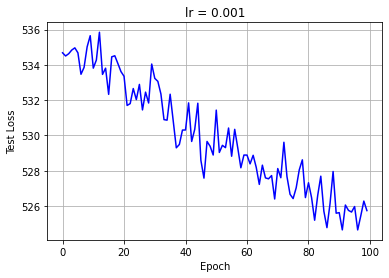

In [77]:
print(np.min(loss_test))
plt.figure(2)
plt.title(f'lr = {learn_rate}')
plt.plot(np.array(loss_test), 'b')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
#plt.yscale('log')
plt.grid()
plt.show()
#np.savez('VAE_Optical_linear_compression_6_512_hidden', data = np.array(loss_test))

In [78]:
dataiter = iter(test_dataset)
model.eval()
with torch.no_grad():
    digits, labels = dataiter.next()
    digits = digits.to(device)
    labels = labels.to(device)
    print(digits.shape)
    output, mean, std = model(digits)
    print(output.shape)
print(kl_loss(mean, std))

torch.Size([50, 9])
torch.Size([50, 196])
tensor(32.1616, device='cuda:3')


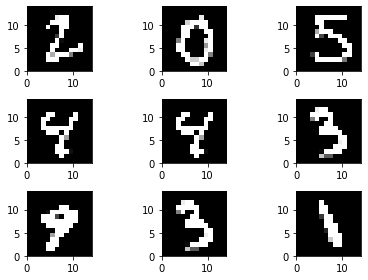

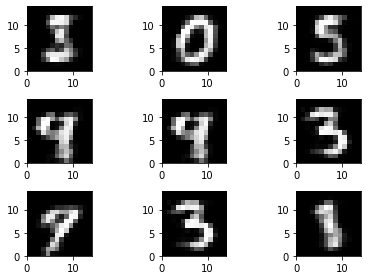

In [95]:
np.random.seed(87)
plots = 9
inds = np.random.randint(0, batch_size, size = plots)    
fig, axes = plt.subplots(int(np.sqrt(plots)), int(np.sqrt(plots)))
for i in range (int(np.sqrt(plots))):
    for j in range (int(np.sqrt(plots))):
        axes[i, j].imshow(labels[inds[i*int(np.sqrt(plots)) + j]].detach().cpu().view(pixels, pixels), interpolation = 'None', \
                       origin='upper', extent=[0, pixels, 0, pixels], cmap = 'gray')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(int(np.sqrt(plots)), int(np.sqrt(plots)))
for i in range (int(np.sqrt(plots))):
    for j in range (int(np.sqrt(plots))):
        axes[i, j].imshow(output[inds[i*int(np.sqrt(plots)) + j]].detach().cpu().view(pixels, pixels), interpolation = 'None', \
                       origin='upper', extent=[0, pixels, 0, pixels], cmap = 'gray')
plt.tight_layout()
plt.show()

In [101]:
class Compressed_Dataset(Dataset):
    def __init__(self, mode) :
        self.mode = mode
        self.data = []
        self.labels = []
        if (mode == 'train'):
            for i, data in enumerate(train_data):
                with torch.no_grad():
                    t, m, v = model(data[0].reshape(1, 9).to(device))
                    self.data.append((t).reshape(196))
                    #self.labels.append(data[0].reshape(784))
                    self.labels.append(training_data_labels[i])
                    #self.labels.append(torch.relu(torch.sign(data[0] - cutoff)))
        if (mode == 'test'):
            for i, data in enumerate(test_data):
                with torch.no_grad():
                    t, m, v = model(data[0].reshape(1, 9).to(device))
                    self.data.append((t).reshape(196))
                    #self.labels.append(data[0].reshape(784)) 
                    self.labels.append(testing_data_labels[i])
                    #self.labels.append(torch.relu(torch.sign(data[0] - cutoff)))
                
    def __len__(self) :
        return len(self.labels)
        
    def __getitem__(self, idx) :
        return self.data[idx], self.labels[idx]
comp_train_data = Compressed_Dataset('train')
comp_test_data = Compressed_Dataset('test')
    
transforms_noise = torchvision.transforms.Compose([torchvision.transforms.RandomAffine(5, translate=(0.02, 0.02), \
                                                                                       scale=(0.98, 1.02)),\
                                                   torchvision.transforms.GaussianBlur(7),\
                                                   torchvision.transforms.Resize((14, 14)),\
                                                   torchvision.transforms.ToTensor()])
#Fashion MNIST
train = torchvision.datasets.MNIST('../../Smart Sensor - Image Compression/MNIST', train=True, download=True, transform=transforms_noise)

test = torchvision.datasets.MNIST('../../Smart Sensor - Image Compression/MNIST', train=False, download=True, transform=transforms_noise)

cutoff = 0.2
class MNIST_Fashion_Dataset(Dataset):
    def __init__(self, mode) :
        self.mode = mode
        self.data = []
        self.labels = []
        if (mode == 'train'):
            for i, data in enumerate(train):
                self.data.append(data[0].reshape(14*14)/data[0].max())
                self.labels.append(data[1])
                #self.labels.append(data[0].reshape(784))
                #self.labels.append(torch.relu(torch.sign(data[0] - cutoff)))
        if (mode == 'test'):
            for i, data in enumerate(test):
                self.data.append(data[0].reshape(14*14)/data[0].max())
                self.labels.append(data[1])
                #self.labels.append(data[0].reshape(784))
                #self.labels.append(torch.relu(torch.sign(data[0] - cutoff)))
                
    def __len__(self) :
        return len(self.labels)
        
    def __getitem__(self, idx) :
        return self.data[idx], self.labels[idx]
    
train_data = MNIST_Fashion_Dataset('train')
test_data = MNIST_Fashion_Dataset('test')

torch.Size([196])
9


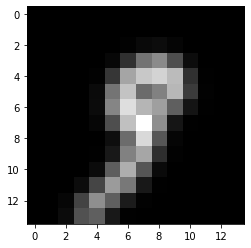

torch.Size([196])
5
torch.Size([196])


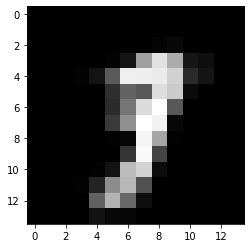

9
torch.Size([196])
5


In [131]:
ind = 19
for i,data in enumerate(train_data):
    if(i==ind):
        print(data[0].shape)
        print(data[1])
        fig, axes = plt.subplots(1, 1)
        axes.imshow(data[0].reshape(14,14), cmap = 'gray')
        #axes[1].imshow(data[1].reshape(28,28))
        plt.show()
N_train_samp = i + 1
for i,data in enumerate(test_data):
    if(i==15):
        print(data[0].shape)
        print(data[1])
#         fig, axes = plt.subplots(1, 1)
#         axes.imshow(data[0].reshape(14,14))
#         #axes[1].imshow(data[1].reshape(28,28))
#         plt.show()
N_test_samp = i + 1

for i,data in enumerate(comp_train_data):
    if(i==ind):
        print(data[0].shape)
        plt.figure()
        plt.imshow(data[0].detach().cpu().reshape(14,14), cmap = 'gray')
        plt.show()
        print(data[1])
N_comp_train_samp = i + 1
for i,data in enumerate(comp_test_data):
    if(i==15):
        print(data[0].shape)
#         plt.figure()
#         plt.imshow(data[0].detach().cpu().reshape(14,14), cmap = 'gray')
#         plt.show()
        print(data[1])
N_comp_test_samp = i + 1

In [132]:
batch_size_mnist = 100
train_dataset = DataLoader(train_data, batch_size = batch_size, shuffle = False)
test_dataset = DataLoader(test_data, batch_size = batch_size, shuffle = False)
N_train_batch = int(N_train_samp/batch_size)
N_test_batch = int(N_test_samp/batch_size)
print(N_train_batch)
print(N_test_batch)

batch_size_comp = 50
comp_train_dataset = DataLoader(comp_train_data, batch_size = batch_size, shuffle = False)
comp_test_dataset = DataLoader(comp_test_data, batch_size = batch_size, shuffle = False)
N_comp_train_batch = int(N_comp_train_samp/batch_size)
N_comp_test_batch = int(N_comp_test_samp/batch_size)
print(N_comp_train_batch)
print(N_comp_test_batch)

1200
200
40
6


In [133]:
class Classifier(nn.Module):
    def __init__(self, n_inps, n_outs, batch):
        super(Classifier, self).__init__()
        self.n_inputs = n_inps
        self.n_outputs = n_outs
        self.FC1 = nn.Linear(self.n_inputs, 256, bias = True)
        self.FC2 = nn.Linear(256, 128, bias = True)
        self.FC3 = nn.Linear(128, self.n_outputs, bias = True)
    
    def forward(self, X):
        Y = self.FC1(X)
        Y = F.relu(Y)
        Y = self.FC2(Y)
        Y = F.relu(Y)
        Y = self.FC3(Y)
        return Y

In [134]:
def get_accuracy(logit, target):
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects
    return accuracy.item()

In [135]:
dataiter = iter(comp_train_dataset)
if (device != "cpu") :
    with torch.cuda.device(dev):
        torch.cuda.empty_cache()
        
with torch.no_grad():
    digits, labels = dataiter.next()
    digits = digits.to(device)
    labels = labels.to(device)
    print(digits.shape)
    model2 = Classifier(196, 10, batch_size).to(device)
    output = model2(digits)
    print(labels.shape)
    print(output.shape)
    
criterion = nn.CrossEntropyLoss()
print(criterion(output, labels))
print(torch.max(output, 1)[1].view(labels.size()) == labels)

torch.Size([50, 196])
torch.Size([50])
torch.Size([50, 10])
tensor(2.2894, device='cuda:3')
tensor([False,  True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, False, False],
       device='cuda:3')


In [136]:
learn_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learn_rate, weight_decay=0.001)
Epochs = 120
if (device != "cpu") :
    with torch.cuda.device(dev):
        torch.cuda.empty_cache()
        
loss_train = []
loss_test = []
acc_train = []
acc_test = []

model2.eval()
train_running_loss = 0.0
train_acc = 0.0
test_acc = 0.0
with torch.no_grad():
    for i, data in enumerate(train_dataset):
        # zero the parameter gradients
        optimizer.zero_grad()
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # forward + backward + optimize
        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels)         
    acc_train.append(train_acc/N_train_batch)
    loss_train.append(train_running_loss/N_train_samp)    
    for p, tdata in enumerate(test_dataset):
        t_inputs, t_labels = tdata
        t_inputs, t_labels = t_inputs.to(device), t_labels.to(device)
        t_outputs = model2(t_inputs)
        test_acc += get_accuracy(t_outputs, t_labels)
    acc_test.append(test_acc/N_test_samp)
print('Inital Train Loss: %.4f | Initial Train Accuracy: %.2f' 
          %(train_running_loss/N_train_batch, train_acc/N_train_samp))
print('Initial Test Accuracy: %.2f' 
          %(test_acc/N_test_samp))
for epoch in range(Epochs):# loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    test_acc = 0.0
    model2.train()
    # TRAINING ROUND
    for i, data in enumerate(train_dataset):
        # zero the parameter gradients
        optimizer.zero_grad()
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # forward + backward + optimize
        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        #print(loss.detach().item())
        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels)
    model2.eval()
    acc_train.append(train_acc/N_train_samp)
    loss_train.append(train_running_loss/(N_train_batch))#*batch_size))
    if (epoch%(Epochs/10) == 0) :
        print('Progress:  %d | Loss: %.4f | Accuracy: %.2f'\
              %(100*epoch/Epochs, train_running_loss/(N_train_batch), train_acc/N_train_samp))#*batch_size)))
    with torch.no_grad():
        t_loss = 0.
        t_acc = 0.
        for p, tdata in enumerate(test_dataset):
            t_inputs, t_labels = tdata
            t_inputs = t_inputs.to(device)
            t_labels = t_labels.to(device)
            t_outputs = model2(t_inputs)
            t_loss += criterion(t_outputs, t_labels).detach().item()
            test_acc += get_accuracy(t_outputs, t_labels)
        acc_test.append(test_acc/N_test_samp)
        loss_test.append(t_loss/(N_test_batch))#*batch_size))
        #acc_test.append(t_acc/N_test_batch)
    if (epoch%(Epochs/10) == 0) :
        print('Test Loss: %.6f | Test Accuracy: %.4f' 
          %(t_loss/(N_test_batch), test_acc/N_test_samp))
#         print('Test Loss: %.6f' 
#           %(t_loss/(N_test_batch)))#*batch_size)))

Inital Train Loss: 2.2956 | Initial Train Accuracy: 9.94
Initial Test Accuracy: 9.90
Progress:  0 | Loss: 0.4288 | Accuracy: 87.24
Test Loss: 0.241981 | Test Accuracy: 92.2700
Progress:  10 | Loss: 0.1149 | Accuracy: 96.58
Test Loss: 0.131968 | Test Accuracy: 95.7800
Progress:  20 | Loss: 0.1051 | Accuracy: 96.91
Test Loss: 0.117758 | Test Accuracy: 96.2800
Progress:  30 | Loss: 0.1021 | Accuracy: 97.00
Test Loss: 0.115710 | Test Accuracy: 96.3400
Progress:  40 | Loss: 0.0998 | Accuracy: 97.12
Test Loss: 0.110410 | Test Accuracy: 96.5800
Progress:  50 | Loss: 0.0980 | Accuracy: 97.19
Test Loss: 0.111898 | Test Accuracy: 96.4400
Progress:  60 | Loss: 0.0972 | Accuracy: 97.22
Test Loss: 0.108130 | Test Accuracy: 96.6200
Progress:  70 | Loss: 0.0968 | Accuracy: 97.25
Test Loss: 0.106259 | Test Accuracy: 96.6800
Progress:  80 | Loss: 0.0964 | Accuracy: 97.26
Test Loss: 0.104877 | Test Accuracy: 96.7800
Progress:  90 | Loss: 0.0961 | Accuracy: 97.26
Test Loss: 0.103880 | Test Accuracy: 96.8

96.88


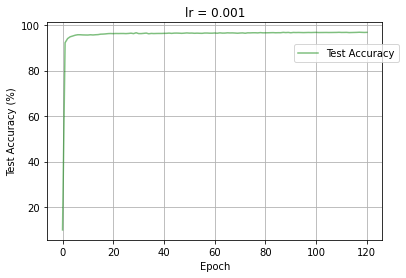

In [137]:
print(np.max(acc_test))
plt.figure()
plt.title(f'lr = {learn_rate}')
#plt.plot(np.array(acc_train), 'b', label = 'Training Accuracy')
plt.plot(np.array(acc_test), 'g', label = 'Test Accuracy', alpha = 0.5)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
#plt.yticks([0,10,20,30,40,50,60,70,80,90,100])
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 0.9), borderaxespad=0.)
plt.show()

In [138]:
learn_rate = 0.00005
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learn_rate, weight_decay=0.001)
Epochs = 50
if (device != "cpu") :
    with torch.cuda.device(dev):
        torch.cuda.empty_cache()
        
loss_train = []
loss_test = []
acc_train = []
acc_test = []

model2.eval()
train_running_loss = 0.0
train_acc = 0.0
test_acc = 0.0
with torch.no_grad():
    for i, data in enumerate(comp_train_dataset):
        # zero the parameter gradients
        optimizer.zero_grad()
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # forward + backward + optimize
        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels)         
    acc_train.append(train_acc/N_comp_train_batch)
    loss_train.append(train_running_loss/N_comp_train_samp)    
    for p, tdata in enumerate(comp_test_dataset):
        t_inputs, t_labels = tdata
        t_inputs, t_labels = t_inputs.to(device), t_labels.to(device)
        t_outputs = model2(t_inputs)
        test_acc += get_accuracy(t_outputs, t_labels)
    acc_test.append(test_acc/N_comp_test_samp)
print('Inital Train Loss: %.4f | Initial Train Accuracy: %.2f' 
          %(train_running_loss/N_comp_train_batch, train_acc/N_comp_train_samp))
print('Initial Test Accuracy: %.2f' 
          %(test_acc/N_comp_test_samp))
for epoch in range(Epochs):# loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    test_acc = 0.0
    model2.train()
    # TRAINING ROUND
    for i, data in enumerate(comp_train_dataset):
        # zero the parameter gradients
        optimizer.zero_grad()
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # forward + backward + optimize
        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        #print(loss.detach().item())
        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels)
    model2.eval()
    acc_train.append(train_acc/N_comp_train_samp)
    loss_train.append(train_running_loss/(N_comp_train_batch))#*batch_size))
    if (epoch%(Epochs/10) == 0) :
        print('Progress:  %d | Loss: %.4f | Accuracy: %.2f'\
              %(100*epoch/Epochs, train_running_loss/(N_comp_train_batch), train_acc/N_comp_train_samp))#*batch_size)))
    with torch.no_grad():
        t_loss = 0.
        t_acc = 0.
        for p, tdata in enumerate(comp_test_dataset):
            t_inputs, t_labels = tdata
            t_inputs = t_inputs.to(device)
            t_labels = t_labels.to(device)
            t_outputs = model2(t_inputs)
            t_loss += criterion(t_outputs, t_labels).detach().item()
            test_acc += get_accuracy(t_outputs, t_labels)
        acc_test.append(test_acc/N_comp_test_samp)
        loss_test.append(t_loss/(N_comp_test_batch))#*batch_size))
        #acc_test.append(t_acc/N_test_batch)
    if (epoch%(Epochs/10) == 0) :
        print('Test Loss: %.6f | Test Accuracy: %.4f' 
          %(t_loss/(N_comp_test_batch), test_acc/N_comp_test_samp))
#         print('Test Loss: %.6f' 
#           %(t_loss/(N_test_batch)))#*batch_size)))

Inital Train Loss: 0.6921 | Initial Train Accuracy: 82.55
Initial Test Accuracy: 77.00
Progress:  0 | Loss: 0.6679 | Accuracy: 83.25
Test Loss: 0.836421 | Test Accuracy: 78.6667
Progress:  10 | Loss: 0.5454 | Accuracy: 84.50
Test Loss: 0.703380 | Test Accuracy: 81.0000
Progress:  20 | Loss: 0.4904 | Accuracy: 85.80
Test Loss: 0.644976 | Test Accuracy: 82.0000
Progress:  30 | Loss: 0.4526 | Accuracy: 86.70
Test Loss: 0.607749 | Test Accuracy: 82.0000
Progress:  40 | Loss: 0.4259 | Accuracy: 86.85
Test Loss: 0.584799 | Test Accuracy: 82.0000
Progress:  50 | Loss: 0.4067 | Accuracy: 87.15
Test Loss: 0.570157 | Test Accuracy: 80.6667
Progress:  60 | Loss: 0.3919 | Accuracy: 87.55
Test Loss: 0.559972 | Test Accuracy: 80.6667
Progress:  70 | Loss: 0.3800 | Accuracy: 87.95
Test Loss: 0.552820 | Test Accuracy: 81.3333
Progress:  80 | Loss: 0.3698 | Accuracy: 88.10
Test Loss: 0.547734 | Test Accuracy: 81.3333
Progress:  90 | Loss: 0.3611 | Accuracy: 88.05
Test Loss: 0.543818 | Test Accuracy: 82

82.33333333333333


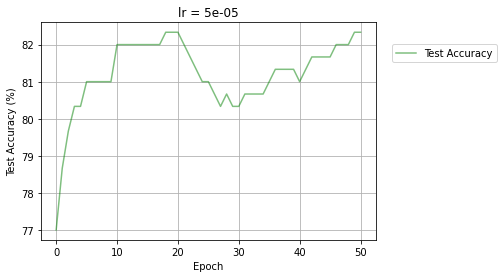

In [139]:
print(np.max(acc_test))
plt.figure()
plt.title(f'lr = {learn_rate}')
#plt.plot(np.array(acc_train), 'b', label = 'Training Accuracy')
plt.plot(np.array(acc_test), 'g', label = 'Test Accuracy', alpha = 0.5)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
#plt.yticks([0,10,20,30,40,50,60,70,80,90,100])
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 0.9), borderaxespad=0.)
plt.show()